In [75]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.grid_search import GridSearchCV
%matplotlib inline

/home/vlad/t_env/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [6]:
labels = []
texts = []
with open('./SMSSpamCollection.txt') as in_file:
    for line in in_file:
        temp = line.split()
        if temp[0] == 'ham':
            labels.append(0)
        else:
            labels.append(1)
        texts.append(' '.join(temp[1:]))

Глянем на распределение по классам

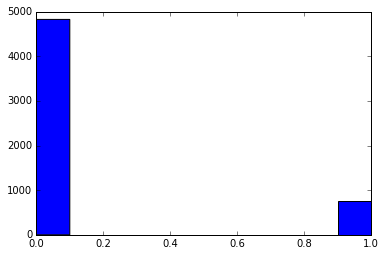

In [74]:
data = pd.read_table('./SMSSpamCollection.txt', delimiter='\t', names=['class', 'text'])
plt.hist(data.values[:, 0] == 'spam')
plt.show()

Видим, что классы очень не сбалансированы.

In [27]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)
X

<5574x8713 sparse matrix of type '<class 'numpy.int64'>'
	with 74169 stored elements in Compressed Sparse Row format>

In [56]:
def evaluate(model, texts, vectorize_class, labels, n_gram_range):
    vectorizer = vectorize_class(ngram_range=n_gram_range)
    X = vectorizer.fit_transform(texts)
    return (sum(cross_val_score(model, X, labels, cv=10, n_jobs=-1, scoring='f1')) / 10)

In [58]:
model = LogisticRegression()
print(evaluate(model, texts, CountVectorizer, labels, n_gram_range=(1, 1)))

0.933348526858


In [14]:
model.fit(X, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
messages = ["FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GB", 
            "FreeMsg: Txt: claim your reward of 3 hours talk time",
            "Have you visited the last lecture on physics?",
            "Have you visited the last lecture on physics? Just buy this book and you will have all materials! Only 99$",
            "Only 99$"
            ]

In [26]:
print(model.predict(vectorizer.transform(messages)))

[1 1 0 0 0]


In [52]:
params = [(1, 1), (2, 2), (3, 3), (1, 3)]

In [63]:
model = LogisticRegression()
for n_gram_range in params:
    print('{}: {:.2f}'.format(n_gram_range, evaluate(model, texts, CountVectorizer, labels, n_gram_range)))

(1, 1): 0.93
(2, 2): 0.82
(3, 3): 0.73
(1, 3): 0.93


In [64]:
model = MultinomialNB()
for n_gram_range in params:
    print('{}: {:.2f}'.format(n_gram_range, evaluate(model, texts, CountVectorizer, labels, n_gram_range)))

(1, 1): 0.93
(2, 2): 0.65
(3, 3): 0.38
(1, 3): 0.89


Качество по понятной причине снижается из-за того, что статистика по биграммам и триграммам довольно плохая, почти все встречаются очень малое число раз.

In [65]:
model = LogisticRegression()
for n_gram_range in params:
    print('{}: {:.2f}'.format(n_gram_range, evaluate(model, texts, TfidfVectorizer, labels, n_gram_range)))

(1, 1): 0.85
(2, 2): 0.34
(3, 3): 0.17
(1, 3): 0.65


Качество понизилось при использовании tf-idf. Наверно на коротких документах tf-idf работает не очень.

Попробуем подобрать параметры.

In [81]:
params = {"regr__max_iter": [100, 200],
          "regr__dual": [True, False],
          "regr__C": [3.0, 1.0, 0.5, 0.1],
          "vec__stop_words": [None, "english"],
          "vec__binary": [True, False],
          "vec__max_features": [None, 3000]}
pipeline = Pipeline(steps = [('vec', CountVectorizer()), ('regr', LogisticRegression())])
gs = GridSearchCV(pipeline, params, cv=10, scoring='f1', n_jobs=-1)
gs.fit(texts, labels)
print(gs.best_params_)
gs.best_score_

{'regr__max_iter': 100, 'vec__stop_words': None, 'vec__binary': True, 'vec__max_features': None, 'regr__dual': True, 'regr__C': 3.0}


0.9418422538286744